In [2]:
import os
import math
import random
import json
import copy
import torch
import numpy as np
import PIL.Image
from tqdm.notebook import tqdm
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
from pathlib import Path
from ossicles_6D_pose_estimation.tools import vis_utils, utils
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from ipywidgets import FloatProgress
from IPython.display import clear_output
from torch.optim.lr_scheduler import _LRScheduler

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate, matrix_to_axis_angle, axis_angle_to_matrix

# rendering components
from pytorch3d.renderer import (
    FoVPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights, TexturesVertex,
    SoftPhongShader, Materials, DirectionalLights, PerspectiveCameras
)

from pytorch3d.renderer.mesh.shading import phong_shading, flat_shading, gouraud_shading
from pytorch3d.renderer.mesh.rasterizer import Fragments

# fix the all seeds possible
seed_number = 42
random.seed(seed_number)
np.random.seed(seed_number)
torch.manual_seed(seed_number)
torch.cuda.manual_seed(seed_number)
torch.cuda.manual_seed_all(seed_number)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Set the cuda device 
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else: device = torch.device("cpu")


In [3]:
class RGBShader(nn.Module):
    def __init__(self, device='cpu', cameras=None, lights=None, materials=None, blend_params=None, shading_type='phong'):
        super().__init__()
        self.lights = lights if lights is not None else DirectionalLights(device=device)
        self.materials = (materials if materials is not None else Materials(device=device))
        self.cameras = cameras
        self.blend_params = blend_params if blend_params is not None else BlendParams()
        if shading_type == 'phong':
            shading_fn = phong_shading
        elif shading_type == 'flat':
            shading_fn = flat_shading
        elif shading_type == 'gouraud':
            shading_fn = gouraud_shading
        elif shading_type == 'raw':
            shading_fn = lambda x: x
        else:
            raise NotImplementedError
        self.shading_fn = shading_fn
        self.shading_type = shading_type

    def forward(self, fragments, meshes, **kwargs):
        blend_params = kwargs.get("blend_params", self.blend_params)
        if self.shading_type == 'raw':
            colors = meshes.sample_textures(fragments)
            if not torch.all(self.lights.ambient_color == 1):
                colors *= self.lights.ambient_color
        else:
            sh_kwargs = {'meshes': meshes, 'fragments': fragments, 'cameras': kwargs.get("cameras", self.cameras),
                         'lights': kwargs.get("lights", self.lights),
                         'materials': kwargs.get("materials", self.materials)}
            if self.shading_type != 'gouraud':
                sh_kwargs['texels'] = meshes.sample_textures(fragments)
            colors = self.shading_fn(**sh_kwargs)
        return rgb_blend(colors, fragments, blend_params)


def rgb_blend(colors, fragments, blend_params, clip_inside=True):
    N, H, W, K = fragments.pix_to_face.shape
    device = fragments.pix_to_face.device
    pixel_colors = torch.ones((N, H, W, 4), dtype=colors.dtype, device=colors.device)
    background_ = blend_params.background_color
    if not isinstance(background_, torch.Tensor):
        background = torch.tensor(background_, dtype=torch.float32, device=device)
    else:
        background = background_.to(device)

    mask = fragments.pix_to_face >= 0  # mask for padded pixels.
    if blend_params.sigma == 0:
        alpha = (fragments.dists <= 0).float() * mask
    elif clip_inside:
        alpha = torch.exp(-fragments.dists.clamp(0) / blend_params.sigma) * mask
    else:
        alpha = torch.sigmoid(-fragments.dists / blend_params.sigma) * mask
    occ_alpha = torch.cumprod(1.0 - alpha, dim=-1)
    occ_alpha = torch.cat([torch.ones(N, H, W, 1, device=device), occ_alpha], dim=-1)
    colors = torch.cat([colors, background[None, None, None, None].expand(N, H, W, 1, -1)], dim=-2)
    alpha = torch.cat([alpha, torch.ones(N, H, W, 1, device=device)], dim=-1)
    """
    Note that the result is not a constant, but rather an aggregate or composite RGB value at each pixel location, which represents the combined contributions from all K layers/fragments at that location.
    In summary, the summation aggregates the contribution of all fragments at each pixel, but it doesn't produce a constant; it produces a tensor of combined RGB values across the image.
    """
    pixel_colors[..., :3] = (occ_alpha[..., None] * alpha[..., None] * colors).sum(-2)

    # pixel_colors[..., 3] = 1 - occ_alpha[:, :, :, -1] # cannot converge with faces_per_pixel ~= 40
    pixel_colors[..., 3] = (1 - occ_alpha).sum(-1) # pixel_colors[..., 3] = occ_alpha.sum(-1) # pixel_colors[..., 3] = 1 - occ_alpha.sum(-1) # works too
    
    return pixel_colors # does not range from 0 to 1, ranges from -1 to 255?

In [4]:
data_path = Path(os.path.abspath("")).parent.parent / "data"

# def normalize(x):
#         if isinstance(x, np.ndarray): return (x - np.min(x)) / (np.max(x) - np.min(x))
#         elif isinstance(x, torch.Tensor): return (x - torch.min(x)) / (torch.max(x) - torch.min(x))

# def apply_nocs_texture(verts):
#         if isinstance(verts, np.ndarray): colors = copy.deepcopy(verts)
#         elif isinstance(verts, torch.Tensor): colors = verts.clone()
#         # normalize verts and center it to 0
#         colors[..., 0] = normalize(verts[..., 0])
#         colors[..., 1] = normalize(verts[..., 1])
#         colors[..., 2] = normalize(verts[..., 2])
        
#         return colors

def apply_latlon_texture():
        latlon = utils.load_latitude_longitude(data_path / "latlon" /"ossiclesCoordinateMapping2.json")
        return latlon.astype("float32")

In [5]:
# ortho 6D representation
def cross_product( u, v):
    batch = u.shape[0]
    #print (u.shape)
    #print (v.shape)
    i = u[:,1]*v[:,2] - u[:,2]*v[:,1]
    j = u[:,2]*v[:,0] - u[:,0]*v[:,2]
    k = u[:,0]*v[:,1] - u[:,1]*v[:,0]
        
    out = torch.cat((i.view(batch,1), j.view(batch,1), k.view(batch,1)),1)#batch*3
        
    return out

def normalize_vector( v, return_mag =False):
    batch=v.shape[0]
    v_mag = torch.sqrt(v.pow(2).sum(1))# batch
    v_mag = torch.max(v_mag, torch.autograd.Variable(torch.FloatTensor([1e-8]).to(device)))
    v_mag = v_mag.view(batch,1).expand(batch,v.shape[1])
    v = v/v_mag
    if(return_mag==True):
        return v, v_mag[:,0]
    else:
        return v

def compute_pose_from_rotation_matrix(T_pose, r_matrix):
    batch=r_matrix.shape[0]
    joint_num = T_pose.shape[0]
    r_matrices = r_matrix.view(batch,1, 3,3).expand(batch,joint_num, 3,3).contiguous().view(batch*joint_num,3,3)
    src_poses = T_pose.view(1,joint_num,3,1).expand(batch,joint_num,3,1).contiguous().view(batch*joint_num,3,1)
        
    out_poses = torch.matmul(r_matrices, src_poses) #(batch*joint_num)*3*1
        
    return out_poses.view(batch, joint_num,3)

def compute_rotation_matrix_from_ortho6d(poses):
    x_raw = poses[:,0:3]#batch*3
    y_raw = poses[:,3:6]#batch*3
        
    x = normalize_vector(x_raw) #batch*3
    z = cross_product(x,y_raw) #batch*3
    z = normalize_vector(z)#batch*3
    y = cross_product(z,x)#batch*3
        
    x = x.view(-1,3,1)
    y = y.view(-1,3,1)
    z = z.view(-1,3,1)
    matrix = torch.cat((x,y,z), 2) #batch*3*3
    return matrix

In [11]:
folderid = "2023-11-15-17-49-32" # batch size equals to 256
fold_num = 0
train_folder = f"{folderid}_train" 
valid_folder = f"{folderid}_valid_sample_best256"
ossicles_name = 6602
id = "0_1"
ossicles_side = "right"

# Get ossicles mesh
if ossicles_name == 6751: 
    video_path = "CIP.6751.1844636424484_video_trim"
elif ossicles_name == 6087:
    video_path = "CIP.6087.8415865242263_video_trim"
elif ossicles_name == 6329:
    video_path = "CIP.6329.6010707468438_vieo_trim"
elif ossicles_name == 489:
    video_path = "CIP.489.1281493978299_video_trim"
elif ossicles_name == 632:
    video_path = "CIP.632.8381493978443_video_trim"
elif ossicles_name == 6602:
    video_path = "CIP.6602.7866163404219_video_trim"
elif ossicles_name == 6088:
    video_path = "CIP.6088.1681356523312_video_trim"
elif ossicles_name == 6320:
    video_path = "CIP.6320.5959167268122_video_trim"
elif ossicles_name == 5997:
    video_path = "CIP.5997.8381493978443_video_trim"
elif ossicles_name == 6742:
    video_path = "CIP.6742.8381574350255_video_trim"
elif ossicles_name == 539:
    video_path = "CIP.539.1929091231231_video_trim"
elif ossicles_name == 455:
    video_path = "CIP.455.8381493978235_video_trim"
elif ossicles_name == 486:
    video_path = "CIP.486.1381493978240_video_trim"
elif ossicles_name == 487:
    video_path = "CIP.487.8381493978240_video_trim"
elif ossicles_name == 488:
    video_path = "CIP.488.8381493978299_video_trim"

meshpath = data_path / "intraop" / video_path / "mesh" / "processed_meshes" / f"{ossicles_name}_{ossicles_side}_ossicles_processed.mesh"
mesh = vis_utils.load_meshobj(meshpath)
idx = np.where(mesh.orient != np.array((1,2,3)))
for i in idx: mesh.vertices[i] = (mesh.dim[i] - 1).reshape((-1,1)) - mesh.vertices[i]
mesh.vertices = mesh.vertices * mesh.sz.reshape((-1, 1))
verts = torch.tensor(mesh.vertices.T, dtype=torch.float32, device=device)
faces = torch.tensor(mesh.triangles.T, dtype=torch.float32, device=device)

verts_rgb = apply_latlon_texture()[None]
textures = TexturesVertex(verts_features=torch.from_numpy(verts_rgb).to(device))

# Create a Meshes object for the teapot. Here we have only one mesh in the batch.
teapot_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

# # Render the plotly figure
# fig = plot_scene({
#     "Ossicles": {
#         "ossicles_mesh": teapot_mesh
#     }
# })

# fig.show()


In [12]:
json_file = data_path.parent / "ossicles_6D_pose_estimation" / "differential_render" / "config.json"
with open(json_file, 'r') as f: config = json.load(f)

gt_pose = np.load(data_path / "raw_dataset" / "poses" / f"{ossicles_name}_{ossicles_side}_gt_pose.npy").astype(np.float32)

imageH=config['image_size'][0]
imageW=config['image_size'][1]

if [imageH, imageW] == [1080, 1920]: 
    zoom_factor = 1
elif [imageH, imageW]  == [540, 960]: 
    zoom_factor = 0.5
elif [imageH, imageW]  == [270, 480]: 
    zoom_factor = 0.25
elif [imageH, imageW]  == [108, 192]: 
    zoom_factor = 0.1

focal_length = 10000 * zoom_factor
print(focal_length)

gt_pose[:3, 3] = gt_pose[:3, 3]
gt_R = torch.from_numpy(gt_pose[:3, :3].T).to(device)[None, ...]
gt_T = torch.from_numpy(gt_pose[:3, 3]).to(device)[None, ...] # add the camera z translation to the gt pose
camera = FoVPerspectiveCameras(device=device, R=gt_R, T=gt_T, fov=np.degrees(2.0 * math.atan2(imageH/2.0, focal_length)))

# initialize a light source.
lights = DirectionalLights(ambient_color=((1, 1, 1), ), diffuse_color=((0, 0, 0), ), specular_color=((0, 0, 0), ), direction=((0, 0, 0), ), device=device)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(0, 0, 0)) # black background
# blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(1, 1, 1)) # white background

1000.0


In [13]:
sigma = 1e-4
rgb_raster_settings = RasterizationSettings(
    image_size=(imageH, imageW),
    # blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    # faces_per_pixel=50, 
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    faces_per_pixel=150, 
    perspective_correct=False,
)

phong_raster_settings = RasterizationSettings(
    image_size=(imageH, imageW),
    # blur_radius=np.log(1. / 1e-4 - 1.)*sigma, 
    # faces_per_pixel=50, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    perspective_correct=False,
)

# print(raster_settings_soft.blur_radius)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_rgb = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=rgb_raster_settings
    ),
    shader=RGBShader(device=device, cameras=camera, lights=lights, blend_params=blend_params)
)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=phong_raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=camera, lights=lights, blend_params=blend_params)
)

In [14]:
class Model(nn.Module):
    def __init__(self, focal_length, meshes, renderer, image_ref, binary_ref):
        super().__init__()
        self.focal_length = focal_length
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer
        
        # Get the silhouette of the reference RGB image by finding all non-white pixel values. 
        # image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)
        self.register_buffer('binary_ref', binary_ref)
        
        """
        # Create an optimizable parameter for the x, y, z position of the camera.
        """
        init_pose = np.load(data_path / "output" / "differential_render" / f"{imageH}_{imageW}" / valid_folder / f"fold_{fold_num}" / "poses" / "predict" / f"{ossicles_name}_{ossicles_side}_ossicles_processed_{id}.npy").astype(np.float32)
        R = torch.from_numpy(np.array(init_pose[:3, :3], dtype=np.float32)).to(device).t()
        t = torch.from_numpy(np.array(init_pose[:3, 3], dtype=np.float32)).to(device)   #  - np.array([0, 0, 20])
        
        T_pose = torch.FloatTensor(np.array([[1,0,0],[0,1,0], [0,0,1]])).to(device)
        pose = compute_pose_from_rotation_matrix(T_pose, R[None])
        pose = pose.view(1, -1)[..., :6]
        recovered_r = compute_rotation_matrix_from_ortho6d(pose)
        assert torch.isclose(R[None], recovered_r).all(), "Rotation matrix not recovered correctly"
        self.camera_rotation = nn.Parameter(pose)
        """
        r_axis_angle = matrix_to_axis_angle(R)
        self.camera_rotation = nn.Parameter(r_axis_angle)
        """
        self.camera_position = nn.Parameter(t) 
        
    def forward(self):
        R = compute_rotation_matrix_from_ortho6d(self.camera_rotation)
        T = self.camera_position[None, ...]
        cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=np.degrees(2.0 * math.atan2(imageH/2.0, self.focal_length))) # values from pyvista
        image = self.renderer(meshes_world=self.meshes.clone(), cameras=cameras)

        # Calculate the rgb loss
        
        loss = torch.sum((torch.clip(image[..., :3], 0, 255) * self.binary_ref - torch.clip(self.image_ref[..., :3], 0, 255)) ** 2)

        return loss, image * self.binary_ref

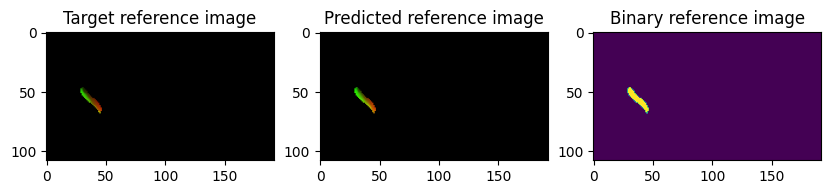

In [19]:
target_image_ref = np.array(PIL.Image.open(data_path / "output" / "differential_render" / f"{imageH}_{imageW}" / valid_folder / f"fold_{fold_num}" / "mapping" / "target" / f"{ossicles_name}_{ossicles_side}_ossicles_processed_{id}.png")) / 255
color_image_ref = np.array(PIL.Image.open(data_path / "output" / "differential_render" / f"{imageH}_{imageW}" / valid_folder / f"fold_{fold_num}" / "mapping" / "predict" / f"{ossicles_name}_{ossicles_side}_ossicles_processed_{id}.png")) / 255
binary_image_ref = utils.color2binary_mask(target_image_ref)
target_ref = torch.from_numpy(target_image_ref).float().to(device)
image_ref = torch.from_numpy(color_image_ref).float().to(device)
binary_ref = torch.from_numpy(binary_image_ref).float().to(device)

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(target_ref.clone().squeeze().cpu().numpy())
plt.title("Target reference image")
plt.subplot(132)
plt.imshow(image_ref.clone().squeeze().cpu().numpy())
plt.title("Predicted reference image")
plt.subplot(133)
plt.imshow(binary_ref.clone().squeeze().cpu().numpy())
plt.title("Binary reference image")
plt.grid(False)

1.0
3.5546055


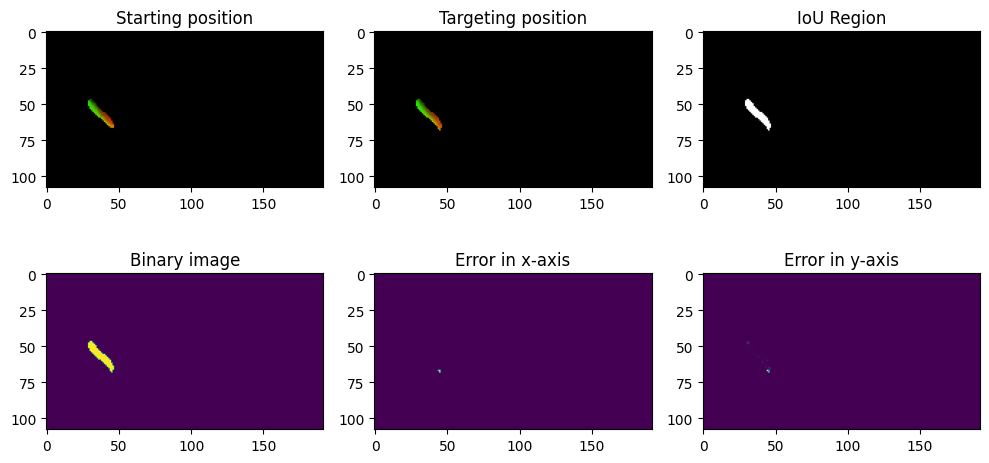

(108, 192, 3)


In [20]:
# %matplotlib notebook
%matplotlib inline
# calculate the IOU
def compute_iou(img1, img2):
    # mask1 = (np.sum(img1, axis=-1) > 0).astype(np.uint8)
    # mask2 = (np.sum(img2, axis=-1) > 0).astype(np.uint8)
    mask1 = utils.color2binary_mask(img1)[..., 0]
    mask2 = utils.color2binary_mask(img2)[..., 0]
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return mask1, mask2, intersection / union

# Initialize a model using the renderer, mesh and reference image
model = Model(focal_length=focal_length, meshes=teapot_mesh, renderer=renderer_rgb, image_ref=image_ref, binary_ref=binary_ref).to(device)
# model = Model(focal_length=focal_length, meshes=teapot_mesh, renderer=renderer_rgb, image_ref=target_ref, binary_ref=binary_ref).to(device)

_, image_init = model()
img1 = image_init.detach().squeeze().cpu().numpy()[..., :3]
img2 = model.image_ref[..., :3].cpu().numpy().squeeze()

mask1, mask2, res = compute_iou(img1, img2)
print(res)

def visualize_region(img1, img2, mask1, mask2, title):

    # plt.cla()   # Clear axis
    # plt.clf()   # Clear figure
    # plt.close() # Close a figure window
    plt.figure(figsize=(10, 5))
    
    intersection = np.logical_and(mask1, mask2)
    
    # Create an output image to visualize the IoU region
    output = np.zeros(img1.shape, dtype=img1.dtype)
    output[intersection] = [1, 1, 1]

    plt.subplot(231)
    # plt.imshow(np.clip(img1, 0, 1))
    plt.imshow(np.clip(img1, 0, 1))
    plt.title(title)
    
    plt.subplot(232)
    # plt.imshow(np.clip(img2, 0, 1))
    plt.imshow(np.clip(img2, 0, 1))
    plt.title('Targeting position')
    
    plt.subplot(233)
    plt.imshow(output)
    plt.title('IoU Region')

    plt.subplot(234)
    plt.imshow(binary_image_ref)
    plt.title('Binary image')

    # find the error in each axis
    error = (np.clip(img1, 0, 255) * binary_image_ref - np.clip(img2, 0, 255)) ** 2
    print(np.sum(error))
    plt.subplot(235)
    plt.imshow(error[..., 0])
    plt.title('Error in x-axis')

    plt.subplot(236)
    plt.imshow(error[..., 1])
    plt.title('Error in y-axis')

    plt.tight_layout()
    plt.show()

visualize_region(img1, img2, mask1, mask2, "Starting position")
print(img2.shape)

In [36]:
filename_output = str(data_path / "output" / "optimizer" / f"optimizer_{ossicles_name}_demo.gif")
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

class PolyLRScheduler(_LRScheduler):
    def __init__(self, optimizer, initial_lr: float, max_steps: int, exponent: float = 0.9, current_step: int = None):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.max_steps = max_steps
        self.exponent = exponent
        self.ctr = 0
        super().__init__(optimizer, current_step if current_step is not None else -1, False)

    def step(self, current_step=None):
        if current_step is None or current_step == -1:
            current_step = self.ctr
            self.ctr += 1

        new_lr = self.initial_lr * (1 - current_step / self.max_steps) ** self.exponent
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = new_lr
clear_output(wait=True)
iterations = 100000
loop = tqdm(range(iterations))
lr_scheduler = PolyLRScheduler(optimizer=optimizer, initial_lr=optimizer.state_dict()['param_groups'][0]['lr'], max_steps=iterations)
best_loss = 1e10
save_best_image = np.zeros((108, 192, 3))
try:
    for i in loop:
        lr_scheduler.step(i)
        optimizer.zero_grad()
        loss, image = model()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        loop.set_description('Optimizing (loss %.4f)' % loss.data)

        if loss < best_loss:
            best_loss = loss
            best_r = compute_rotation_matrix_from_ortho6d(model.camera_rotation).clone()
            best_t = model.camera_position[None, ...].clone()
            save_best_image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        
        # Save outputs to create a GIF. 
        if i % 100 == 0:
            R = compute_rotation_matrix_from_ortho6d(model.camera_rotation)
            T = model.camera_position[None, ...]
            current_camera = FoVPerspectiveCameras(device=device, R=R, T=T, fov=np.degrees(2.0 * math.atan2(imageH/2.0, focal_length)))
            current_image = renderer_rgb(meshes_world=model.meshes.clone(), cameras=current_camera)
            current_image = current_image[0, ..., :3].detach().squeeze().cpu().numpy()
            current_image = np.clip(current_image, 0, 1)
            current_image = img_as_ubyte(current_image)
            writer.append_data(current_image)
            
            # image = image[0, ..., :3].detach().squeeze().cpu().numpy()
            # image = np.clip(image, 0, 1)
            # image = img_as_ubyte(image)
            # writer.append_data(image)
except KeyboardInterrupt:
    pass
print(f"best_loss: {best_loss}")
print(f"\nbest_R: {best_r}, best_t: {best_t}")
print(f"gt_R: {gt_R}, gt_T: {gt_T}")
writer.close()
plt.savefig(data_path / "output" / "optimizer" / "optimizer_demo.png")

  0%|          | 0/100000 [00:00<?, ?it/s]

best_loss: 0.8421684503555298

best_R: tensor([[[ 0.2167, -0.2105,  0.9533],
         [ 0.4262, -0.8581, -0.2864],
         [ 0.8783,  0.4684, -0.0962]]], device='cuda:0',
       grad_fn=<CloneBackward0>), best_t: tensor([[  6.1114,   0.1276, 117.8784]], device='cuda:0',
       grad_fn=<CloneBackward0>)
gt_R: tensor([[[ 0.0475, -0.2082,  0.9770],
         [ 0.3986, -0.8929, -0.2097],
         [ 0.9159,  0.3993,  0.0406]]], device='cuda:0'), gt_T: tensor([[    5.0370,     0.0179,   109.5427]], device='cuda:0')


<Figure size 640x480 with 0 Axes>

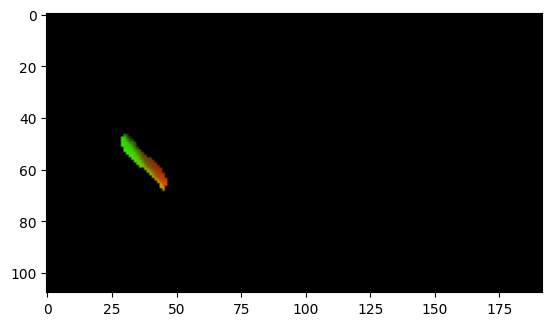

In [43]:
plt.imshow(save_best_image)
plt.show()

# save_best_image = PIL.Image.fromarray((save_best_image * 255).astype(np.uint8))
# save_best_image.save(data_path / "output" / "optimizer" / f"optimizer_{ossicles_name}_demo.png")

# save_best_image = np.clip(save_best_image, 0, 1)

tensor([[[ 0.2139, -0.2109,  0.9538],
         [ 0.4264, -0.8583, -0.2855],
         [ 0.8789,  0.4677, -0.0937]]], device='cuda:0',
       grad_fn=<CatBackward0>)
tensor([[[ 0.2167, -0.2105,  0.9533],
         [ 0.4262, -0.8581, -0.2864],
         [ 0.8783,  0.4684, -0.0962]]], device='cuda:0',
       grad_fn=<CloneBackward0>)
tensor([[  6.0821,   0.1255, 117.5601]], device='cuda:0',
       grad_fn=<AsStridedBackward0>)
tensor([[  6.1114,   0.1276, 117.8784]], device='cuda:0',
       grad_fn=<CloneBackward0>)
torch.Size([108, 192, 3])


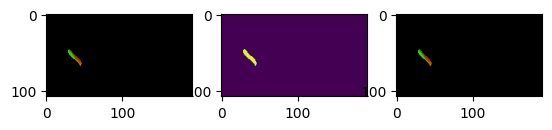

In [44]:
camera = FoVPerspectiveCameras(device=device, R=R, T=T, fov=np.degrees(2.0 * math.atan2(imageH/2.0, focal_length)))
image = renderer_rgb(meshes_world=teapot_mesh, cameras=camera)[0, ..., :3] #.detach().squeeze().cpu().numpy()
image = image * binary_ref

print(R)
print(best_r)

print(T)
print(best_t)

# plt.imshow(image[0, ..., :3].detach().squeeze().cpu().numpy())
print(image.shape)

plt.subplot(131)
plt.imshow(image.detach().squeeze().cpu().numpy())
plt.subplot(132)
plt.imshow(binary_ref.detach().squeeze().cpu().numpy())
plt.subplot(133)
plt.imshow(save_best_image)

# mask1, mask2, _ = compute_iou(save_best_image, image)
# visualize_region(save_best_image, image, mask1, mask2, "Final Position")


0.84216845


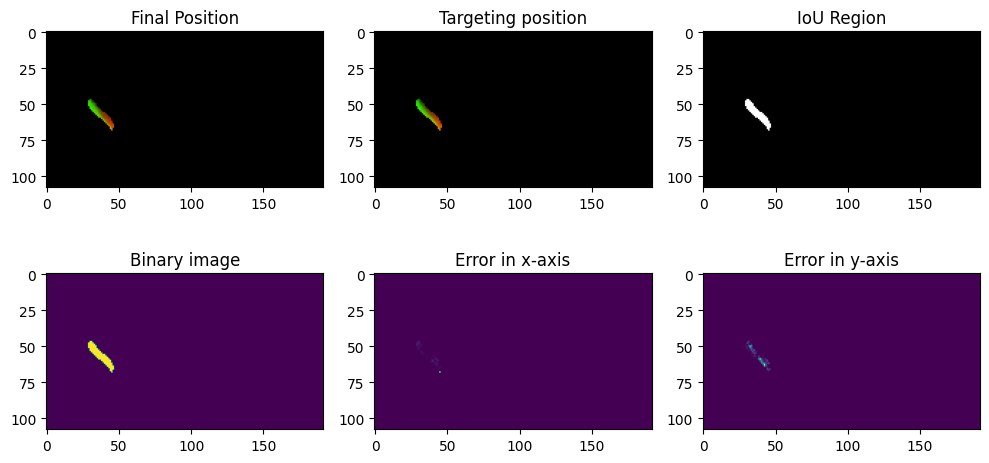

In [45]:
gt_image = model.image_ref.detach().squeeze().cpu().numpy()[..., :3]
mask1, mask2, _ = compute_iou(save_best_image, gt_image)
visualize_region(save_best_image, gt_image, mask1, mask2, "Final Position")

tensor(0.8422, device='cuda:0', grad_fn=<SumBackward0>)
tensor(54819.1289, device='cuda:0', grad_fn=<SumBackward0>)
0.0
0.84287924


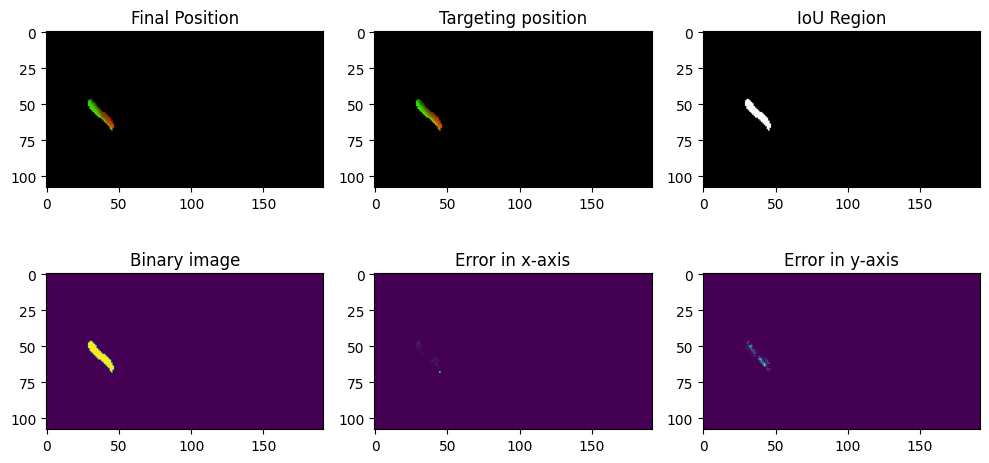

In [46]:
best_image = renderer_rgb(meshes_world=model.meshes.clone(), 
                    cameras=FoVPerspectiveCameras(device=device, R=best_r, T=best_t, fov=np.degrees(2.0 * math.atan2(imageH/2.0, focal_length))))
error = torch.sum((torch.clip(image[..., :3], 0, 1) * model.binary_ref * 255 - torch.clip(model.image_ref[..., :3], 0, 1) * 255) ** 2)
print(best_loss)
print(error)
best_image = torch.clip(best_image, 0, 1).detach().squeeze().cpu().numpy()[..., :3] * binary_image_ref
print(np.min(best_image))
gt_image = model.image_ref.detach().squeeze().cpu().numpy()[..., :3]

mask1, mask2, _ = compute_iou(best_image, gt_image)
visualize_region(best_image, gt_image, mask1, mask2, "Final Position")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 0.2167, -0.2105,  0.9533],
         [ 0.4262, -0.8581, -0.2864],
         [ 0.8783,  0.4684, -0.0962]]], device='cuda:0',
       grad_fn=<CloneBackward0>) tensor([[  6.1114,   0.1276, 117.8784]], device='cuda:0',
       grad_fn=<CloneBackward0>)
tensor([[[ 0.0475, -0.2082,  0.9770],
         [ 0.3986, -0.8929, -0.2097],
         [ 0.9159,  0.3993,  0.0406]]], device='cuda:0') tensor([[    5.0370,     0.0179,   109.5427]], device='cuda:0')


Text(0.5, 1.0, 'rendered image from pnp algorithm')

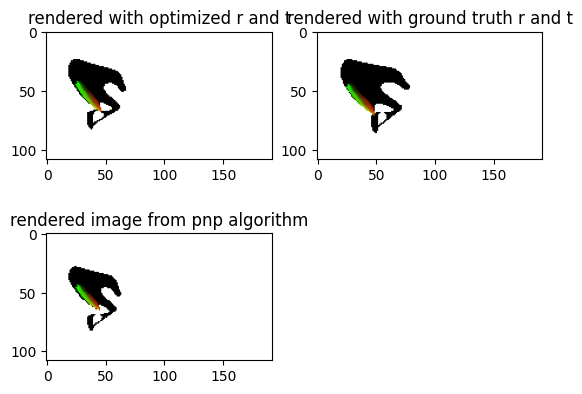

In [47]:

plt.cla()   # Clear axis
plt.clf()   # Clear figure
plt.close() # Close a figure window

camera = FoVPerspectiveCameras(device=device, R=best_r, T=best_t, fov=np.degrees(2.0 * math.atan2(imageH/2.0, focal_length)))
# initialize a light source.
lights = DirectionalLights(ambient_color=((1, 1, 1), ), diffuse_color=((0, 0, 0), ), specular_color=((0, 0, 0), ), direction=((0, 0, 0), ), device=device)
blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(1, 1, 1))

plt.subplot(221)
print(best_r, best_t)
phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera, 
        raster_settings=phong_raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=camera, lights=lights, blend_params=blend_params)
)
render_hard_phong = phong_renderer(meshes_world=teapot_mesh, camera=camera).float()
plt.imshow(render_hard_phong[..., :3].clone().squeeze().detach().cpu().numpy())
plt.title("rendered with optimized r and t")

plt.subplot(222)
print(gt_R, gt_T)
gt_camera = FoVPerspectiveCameras(device=device, R=gt_R, T=gt_T, fov=np.degrees(2.0 * math.atan2(imageH/2.0, focal_length)))
gt_phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=gt_camera, 
        raster_settings=phong_raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=camera, lights=lights, blend_params=blend_params)
)

gt_hard_phong = gt_phong_renderer(meshes_world=teapot_mesh).float()
plt.imshow(gt_hard_phong[..., :3].clone().squeeze().detach().cpu().numpy())
plt.title("rendered with ground truth r and t")

plt.subplot(223)
plt.imshow(np.array(PIL.Image.open(data_path / "output" / "differential_render" / f"{imageH}_{imageW}" / valid_folder / f"fold_{fold_num}" / "renders" / "predict" / f"{ossicles_name}_{ossicles_side}_ossicles_processed_{id}.png")))
plt.title("rendered image from pnp algorithm")

# plt.subplot(224)
# init_pose = np.load(data_path / "output" / "differential_render" / valid_folder / f"fold_{fold_num}" / "poses" / "predict" / f"{ossicles_name}_{ossicles_side}_ossicles_processed_{id}.npy").astype(np.float32)
# t = torch.from_numpy(np.array(init_pose[:3, 3], dtype=np.float32)).to(device)
# t = t[None, ...]
# camera = FoVPerspectiveCameras(device=device, R=best_r, T=t, fov=np.degrees(2.0 * math.atan2(imageH/2.0, focal_length)))
# # initialize a light source.
# lights = DirectionalLights(ambient_color=((1, 1, 1), ), diffuse_color=((0, 0, 0), ), specular_color=((0, 0, 0), ), direction=((0, 0, 0), ), device=device)
# blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(1, 1, 1))

# phong_renderer = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=phong_raster_settings
#     ),
#     shader=HardPhongShader(device=device, cameras=camera, lights=lights, blend_params=blend_params)
# )
# render_hard_phong = phong_renderer(meshes_world=teapot_mesh, camera=camera).float()
# plt.imshow(render_hard_phong[..., :3].clone().squeeze().detach().cpu().numpy())
# plt.title("rendered with optimized r and init t")

# plt.show()

In [48]:
print("best pose: ")
print(np.vstack((np.hstack((best_r.squeeze().detach().cpu().numpy(), best_t.squeeze().detach().cpu().numpy().reshape((-1, 1)))), np.array([0,0,0,1]))))
print("ground truth pose: ")
print(np.vstack((np.hstack((gt_R.squeeze().detach().cpu().numpy(), gt_T.squeeze().detach().cpu().numpy().reshape((-1, 1)))), np.array([0,0,0,1]))))

best pose: 
[[  0.216721    -0.21051911   0.95326471   6.11139631]
 [  0.42624184  -0.85807449  -0.28640172   0.12762098]
 [  0.87826526   0.46839058  -0.09623072 117.87837982]
 [  0.           0.           0.           1.        ]]
ground truth pose: 
[[  0.0475033   -0.20822173   0.97697264   5.03700352]
 [  0.39858502  -0.89290375  -0.20965707   0.01794743]
 [  0.91590428   0.39934826   0.04057216 109.54266357]
 [  0.           0.           0.           1.        ]]


### Render sample pose

In [28]:

# # plot the renderer
# pose = [[ -0.29850095,   0.25825895,   0.9188033,    3.21123527],
#  [ -0.51787587,  -0.85247363,   0.07136729,   1.26094412],
#  [  0.80168682,  -0.45452286,   0.38821027, 133.73634032],
#  [  0.,           0.,           0.,           1.        ]]
# pose = torch.from_numpy(np.array(pose)).float().to(device)

# R = pose[:3, :3].t()
# T = pose[:3, 3]

# camera = FoVPerspectiveCameras(device=device, R=R[None, ...], T=T[None, ...], fov=np.degrees(2.0 * math.atan2(imageH/2.0, focal_length)))
# # initialize a light source.
# lights = DirectionalLights(ambient_color=((1, 1, 1), ), diffuse_color=((0, 0, 0), ), specular_color=((0, 0, 0), ), direction=((0, 0, 0), ), device=device)
# blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(1, 1, 1))

# phong_renderer = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=phong_raster_settings
#     ),
#     shader=HardPhongShader(device=device, cameras=camera, lights=lights, blend_params=blend_params)
# )
# render_hard_phong = phong_renderer(meshes_world=teapot_mesh, camera=camera).float()
# plt.subplot(221)
# plt.imshow(render_hard_phong[..., :3].clone().squeeze().detach().cpu().numpy())
# plt.title("rendered with sample pose")

# gt_pose =[[ -0.24130403,  -0.1544932,    0.9691823,    6.080391  ],
#  [ -0.21516955,  -0.96545595,  -0.20751302,   8.369248  ],
#  [  0.9574562,   -0.25587213,   0.19759296, 213.13916   ],
#  [  0.,           0.,           0.,           1.        ]]

# gt_pose = torch.from_numpy(np.array(gt_pose)).float().to(device)

# R = gt_pose[:3, :3].t()
# T = gt_pose[:3, 3]
# plt.subplot(222)
# camera = FoVPerspectiveCameras(device=device, R=R[None, ...], T=T[None, ...], fov=np.degrees(2.0 * math.atan2(imageH/2.0, focal_length)))
# # initialize a light source.
# lights = DirectionalLights(ambient_color=((1, 1, 1), ), diffuse_color=((0, 0, 0), ), specular_color=((0, 0, 0), ), direction=((0, 0, 0), ), device=device)
# blend_params = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(1, 1, 1))

# phong_renderer = MeshRenderer(
#     rasterizer=MeshRasterizer(
#         cameras=camera, 
#         raster_settings=phong_raster_settings
#     ),
#     shader=HardPhongShader(device=device, cameras=camera, lights=lights, blend_params=blend_params)
# )
# render_hard_phong = phong_renderer(meshes_world=teapot_mesh, camera=camera).float()
# plt.imshow(render_hard_phong[..., :3].clone().squeeze().detach().cpu().numpy())
# plt.title("rendered with sample pose")
# """

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(108, 192, 3)


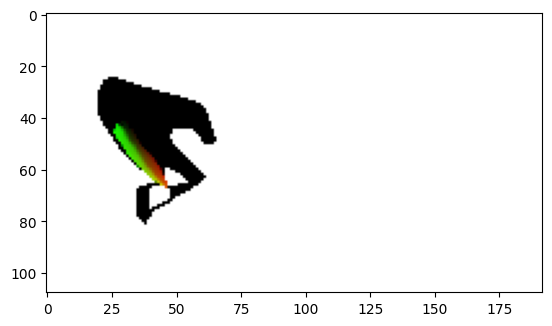

In [29]:
img = render_hard_phong[..., :3].clone().squeeze().detach().cpu().numpy()
plt.imshow(img)
print(img.shape)
img = PIL.Image.fromarray((np.clip(img * 255, 0, 255)).astype(np.uint8))
img.save(data_path / "output" / "optimizer" / f"gt_{ossicles_name}_hard_phong.png")

tensor([[[ 0.2167, -0.2105,  0.9533],
         [ 0.4262, -0.8581, -0.2864],
         [ 0.8783,  0.4684, -0.0962]]], device='cuda:0',
       grad_fn=<CloneBackward0>)
tensor([[  6.1114,   0.1276, 117.8784]], device='cuda:0',
       grad_fn=<CloneBackward0>)
108 192
1000.0
torch.Size([1, 108, 192, 4])
(108, 192, 3)


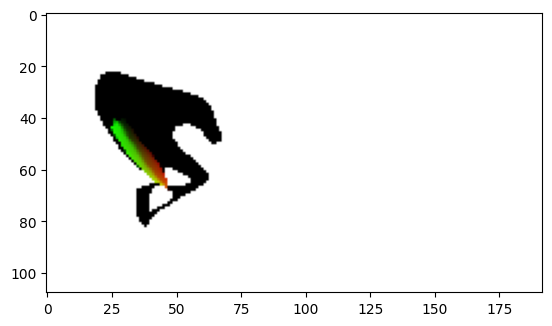

In [49]:
print(best_r)
print(best_t)
print(imageH, imageW)
print(focal_length)
camera1 = FoVPerspectiveCameras(device=device, R=best_r, T=best_t, fov=np.degrees(2.0 * math.atan2(imageH/2.0, focal_length)))
# initialize a light source.
lights1 = DirectionalLights(ambient_color=((1, 1, 1), ), diffuse_color=((0, 0, 0), ), specular_color=((0, 0, 0), ), direction=((0, 0, 0), ), device=device)
blend_params1 = BlendParams(sigma=1e-4, gamma=1e-4, background_color=(1, 1, 1))
raster_settings1 = RasterizationSettings(image_size=(108, 192),
                                        blur_radius=0.0, 
                                        faces_per_pixel=1, 
                                        perspective_correct=False)
# set the shader
softphong_renderer = MeshRenderer(rasterizer=MeshRasterizer(cameras=camera1, raster_settings=raster_settings1),
                            shader=SoftPhongShader(device=device, lights=lights1, blend_params=blend_params1))
# render the target mesh providing the values of R and T
rendered_image1 = phong_renderer(meshes_world=teapot_mesh, cameras=camera1)
print(rendered_image1.shape)
img = torch.clip(rendered_image1[0, ..., :3], 0, 1).squeeze().detach().cpu().numpy()
print(img.shape)
plt.imshow(img)
# img = PIL.Image.fromarray((img * 255).astype(np.uint8))
# img.save("gt_hard_phong.png")
